In [1]:
# Import necessary libraries
import torch
import numpy as np
from scipy.io import loadmat
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.nn import Sequential, Linear
from torch_geometric.nn import NNConv
import torch.nn.functional as F
from tqdm import tqdm
import utm


C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:85: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 指定されたプロシージャが見つかりません。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:123: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 指定されたプロシージャが見つかりません。
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the s

In [2]:
# %% Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [3]:

def signal_strength_to_distance(P_r_dBm, P_t_dBm=13.01, G_t_dBi=0, G_r_dBi=0, f_MHz=915):
    """
    Convert received signal strength (in dBm) to distance (in meters) using the Friis equation.
    """
    # Constants
    constant = 32.44  # Free-space path loss constant in dB for distances in km and frequency in MHz
    
    # Calculate path loss (in dB)
    path_loss_dB = P_t_dBm + G_t_dBi + G_r_dBi - P_r_dBm
    
    # Calculate distance in kilometers
    exponent = (path_loss_dB - 20 * np.log10(f_MHz) - constant) / 20
    distance_km = 10 ** exponent
    
    # Convert distance to meters
    distance_m = distance_km * 1000
    return distance_m


In [4]:
# %% Load data from MATLAB files
num_instances = 1000
data_list = []

for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    # Extract positions and signal strength
    node_latitudes = mat_data['nodeLatitudes'].flatten()
    node_longitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']


    # Convert lat/lon to UTM coordinates
    utm_coords = [utm.from_latlon(lat, lon)[:2] for lat, lon in zip(node_latitudes, node_longitudes)]
    utm_coords = np.array(utm_coords)  # Shape: (num_nodes, 2)

    # Number of nodes
    num_nodes = len(node_latitudes)

    # Create truth locations (latitude and longitude converted to x, y coordinates)
    # truth_location_list = np.column_stack((node_latitudes, node_longitudes))
    # Truth locations in UTM coordinates
    truth_location_list = utm_coords  # Shape: (num_nodes, 2)


    # Compute distances and create edge attributes
    edge_index_list = []
    edge_attr_list = []

    # for i in range(num_nodes):
    #     for j in range(num_nodes):
    #         if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
    #             edge_index_list.append([i, j])
    #             edge_attr_list.append(signal_strength_matrix[i, j, :])  # Use all 10 simulated measurements
    
    # edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    # edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # Extract signal strengths for this edge
                ss_values = signal_strength_matrix[i, j, :]  # Shape: (num_measurements,)
                # Convert signal strengths to distances
                distances = signal_strength_to_distance(ss_values)
                edge_attr_list.append(distances)
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)  # Shape: (num_edges, num_measurements)

    # Create node features
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:4] = True  # First 1 nodes are anchors
    unknown_mask = ~anchor_mask

    # Node features: coordinates and anchor flag (1 for anchor, 0 for unknown)
    node_features = []
    # for i in range(num_nodes):
    #     is_anchor = 1 if i < 1 else 0
    #     node_features.append([node_latitudes[i], node_longitudes[i], is_anchor])

    # Node features: coordinates (anchors only) and anchor flag (1 for anchor, 0 for unknown)
    # for i in range(num_nodes):
    #     is_anchor = 1 if i < 4 else 0  # Adjust if your anchors are not the first 4 nodes
    #     if is_anchor:
    #         node_features.append([node_latitudes[i], node_longitudes[i], is_anchor])
    #     else:
    #         # Initialize unknown nodes' positions with zeros
    #         node_features.append([0.0, 0.0, is_anchor])

    for i in range(num_nodes):
        is_anchor = 1 if i < 4 else 0  # Adjust based on your number of anchors
        if is_anchor:
            # Anchors: Use known positions and an anchor flag
            node_features.append([utm_coords[i][0], utm_coords[i][1], is_anchor])
        else:
            # Unknown nodes: Initialize positions with zeros or estimates
            node_features.append([0.0, 0.0, is_anchor])


    x = torch.tensor(node_features, dtype=torch.float)

    # Labels (ground truth positions)
    y = torch.tensor(truth_location_list, dtype=torch.float)
    
    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    data_list.append(data)

Loading MATLAB data:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\kazuya\AppData\Local\Temp\ipykernel_30432\4224166969.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)  # Shape: (num_edges, num_measurements)
Loading MATLAB data: 100%|██████████| 1000/1000 [00:02<00:00, 365.24it/s]


In [5]:
# # %% Normalize features using StandardScaler
# all_features = torch.cat([data.x for data in data_list], dim=0).numpy()
# scaler = StandardScaler()
# scaler.fit(all_features)

# for data in data_list:
#     data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)
# Collect features from anchor nodes only for fitting the scaler
# all_anchor_features = torch.cat([data.x[data.anchor_mask] for data in data_list], dim=0).numpy()
# scaler = StandardScaler()
# scaler.fit(all_anchor_features)

# # Apply the scaler to all data
# for data in data_list:
#     data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)

all_features = torch.cat([data.x for data in data_list], dim=0).numpy()
scaler = StandardScaler()
scaler.fit(all_features)

for data in data_list:
    data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)

# %% Create DataLoader
train_loader = DataLoader(data_list, batch_size=2, shuffle=True)

C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# %% Define GCN model
class EdgeFeatureNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EdgeFeatureNet, self).__init__()
        self.net = Sequential(
            Linear(input_dim, 64),
            torch.nn.ReLU(),
            Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_feature_dim, num_measurements):
        super(GCN, self).__init__()
        # Edge feature network to process time-series edge attributes
        self.edge_net = EdgeFeatureNet(num_measurements, edge_feature_dim)
        
        # Edge networks for NNConv layers
        nn1 = Sequential(Linear(edge_feature_dim, hidden_dim * input_dim))
        self.conv1 = NNConv(input_dim, hidden_dim, nn1, aggr='mean')
        
        nn2 = Sequential(Linear(edge_feature_dim, hidden_dim * hidden_dim))
        self.conv2 = NNConv(hidden_dim, hidden_dim, nn2, aggr='mean')
        
        self.fc = Linear(hidden_dim, output_dim)
        
        # Projection layers for anchor nodes
        self.anchor_proj1 = Linear(input_dim, hidden_dim)
        self.anchor_proj2 = Linear(hidden_dim, hidden_dim)
    
    def forward(self, x, edge_index, edge_attr, anchor_mask):
        # Process edge attributes using EdgeFeatureNet
        edge_attr_processed = self.edge_net(edge_attr)
        
        # Save the original features of anchor nodes
        x_anchor = x[anchor_mask]
        
        # First GNN layer
        x = self.conv1(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj1(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the projected anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Save the features of anchor nodes after the first layer
        x_anchor = x[anchor_mask]
        
        # Second GNN layer
        x = self.conv2(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj2(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Final fully connected layer
        x = self.fc(x)
        return x

In [7]:
# %% Instantiate model and optimizer
input_dim = data_list[0].x.shape[1]  # Adjust input dimension based on node features
hidden_dim = 64  # Adjust as needed
output_dim = 2   # Predicting x and y coordinates
edge_feature_dim = 32  # Adjust as needed

model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, edge_feature_dim=edge_feature_dim, num_measurements=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


In [8]:
# %% Training loop
model.train()
loss_history = []

for epoch in range(50):
    total_loss = 0

    for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)

        # Compute loss only for unknown nodes
        loss = F.mse_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

Training Epoch 1: 100%|██████████| 500/500 [00:03<00:00, 142.28it/s]


Epoch 1, Loss: 21588642223860563968.0000


Training Epoch 2: 100%|██████████| 500/500 [00:02<00:00, 184.17it/s]


Epoch 2, Loss: 55557513266268736.0000


Training Epoch 3: 100%|██████████| 500/500 [00:02<00:00, 192.38it/s]


Epoch 3, Loss: 129392670938125824.0000


Training Epoch 4: 100%|██████████| 500/500 [00:02<00:00, 198.53it/s]


Epoch 4, Loss: 21133072630189916.0000


Training Epoch 5: 100%|██████████| 500/500 [00:02<00:00, 192.19it/s]


Epoch 5, Loss: 978846114992095.2500


Training Epoch 6: 100%|██████████| 500/500 [00:02<00:00, 174.70it/s]


Epoch 6, Loss: 46657637972820624.0000


Training Epoch 7: 100%|██████████| 500/500 [00:02<00:00, 170.40it/s]


Epoch 7, Loss: 4086532187172634.5000


Training Epoch 8: 100%|██████████| 500/500 [00:03<00:00, 141.67it/s]


Epoch 8, Loss: 1131702345109864.5000


Training Epoch 9: 100%|██████████| 500/500 [00:03<00:00, 143.23it/s]


Epoch 9, Loss: 18218272484490216.0000


Training Epoch 10: 100%|██████████| 500/500 [00:03<00:00, 140.82it/s]


Epoch 10, Loss: 79728136314033280.0000


Training Epoch 11: 100%|██████████| 500/500 [00:03<00:00, 142.82it/s]


Epoch 11, Loss: 172755112771452.9375


Training Epoch 12: 100%|██████████| 500/500 [00:03<00:00, 141.28it/s]


Epoch 12, Loss: 22599837294264.3203


Training Epoch 13: 100%|██████████| 500/500 [00:03<00:00, 141.94it/s]


Epoch 13, Loss: 101091578221690.8750


Training Epoch 14: 100%|██████████| 500/500 [00:03<00:00, 141.32it/s]


Epoch 14, Loss: 46471859213959.1719


Training Epoch 15: 100%|██████████| 500/500 [00:03<00:00, 142.79it/s]


Epoch 15, Loss: 14768326304071.6797


Training Epoch 16: 100%|██████████| 500/500 [00:03<00:00, 144.05it/s]


Epoch 16, Loss: 66761966701510.6562


Training Epoch 17: 100%|██████████| 500/500 [00:03<00:00, 142.95it/s]


Epoch 17, Loss: 6463744553039954.0000


Training Epoch 18: 100%|██████████| 500/500 [00:03<00:00, 141.89it/s]


Epoch 18, Loss: 124669636703682.5625


Training Epoch 19: 100%|██████████| 500/500 [00:03<00:00, 142.40it/s]


Epoch 19, Loss: 175174014717132.8125


Training Epoch 20: 100%|██████████| 500/500 [00:03<00:00, 142.17it/s]


Epoch 20, Loss: 10252717341016.0645


Training Epoch 21: 100%|██████████| 500/500 [00:03<00:00, 143.35it/s]


Epoch 21, Loss: 383734562294595.5625


Training Epoch 22: 100%|██████████| 500/500 [00:03<00:00, 143.00it/s]


Epoch 22, Loss: 11124503116513.2793


Training Epoch 23: 100%|██████████| 500/500 [00:03<00:00, 142.00it/s]


Epoch 23, Loss: 6047117131907.0723


Training Epoch 24: 100%|██████████| 500/500 [00:03<00:00, 140.99it/s]


Epoch 24, Loss: 7295056597483.5195


Training Epoch 25: 100%|██████████| 500/500 [00:03<00:00, 137.61it/s]


Epoch 25, Loss: 10419250910461.9512


Training Epoch 26: 100%|██████████| 500/500 [00:03<00:00, 137.12it/s]


Epoch 26, Loss: 13304437408268.2871


Training Epoch 27: 100%|██████████| 500/500 [00:03<00:00, 141.79it/s]


Epoch 27, Loss: 1693285406349983.7500


Training Epoch 28: 100%|██████████| 500/500 [00:03<00:00, 141.94it/s]


Epoch 28, Loss: 46012687028584.4453


Training Epoch 29: 100%|██████████| 500/500 [00:03<00:00, 138.73it/s]


Epoch 29, Loss: 9598341501419.5195


Training Epoch 30: 100%|██████████| 500/500 [00:03<00:00, 139.98it/s]


Epoch 30, Loss: 10210325049638.9121


Training Epoch 31: 100%|██████████| 500/500 [00:03<00:00, 141.95it/s]


Epoch 31, Loss: 10210309641863.1680


Training Epoch 32: 100%|██████████| 500/500 [00:03<00:00, 139.51it/s]


Epoch 32, Loss: 10210290968821.7598


Training Epoch 33: 100%|██████████| 500/500 [00:03<00:00, 141.90it/s]


Epoch 33, Loss: 10210268426534.9121


Training Epoch 34: 100%|██████████| 500/500 [00:03<00:00, 144.53it/s]


Epoch 34, Loss: 10210241977253.8887


Training Epoch 35: 100%|██████████| 500/500 [00:03<00:00, 142.13it/s]


Epoch 35, Loss: 10210210819866.6230


Training Epoch 36: 100%|██████████| 500/500 [00:03<00:00, 140.43it/s]


Epoch 36, Loss: 10210173643653.1191


Training Epoch 37: 100%|██████████| 500/500 [00:03<00:00, 139.28it/s]


Epoch 37, Loss: 10210129012064.2559


Training Epoch 38: 100%|██████████| 500/500 [00:03<00:00, 143.71it/s]


Epoch 38, Loss: 10210069436170.2402


Training Epoch 39: 100%|██████████| 500/500 [00:03<00:00, 143.61it/s]


Epoch 39, Loss: 10209981498392.5762


Training Epoch 40: 100%|██████████| 500/500 [00:03<00:00, 143.82it/s]


Epoch 40, Loss: 10209799000031.2324


Training Epoch 41: 100%|██████████| 500/500 [00:03<00:00, 142.90it/s]


Epoch 41, Loss: 10211713576075.2637


Training Epoch 42: 100%|██████████| 500/500 [00:03<00:00, 144.12it/s]


Epoch 42, Loss: 10210309228724.2246


Training Epoch 43: 100%|██████████| 500/500 [00:03<00:00, 143.84it/s]


Epoch 43, Loss: 10210257617813.5039


Training Epoch 44: 100%|██████████| 500/500 [00:03<00:00, 141.78it/s]


Epoch 44, Loss: 10210194988466.1758


Training Epoch 45: 100%|██████████| 500/500 [00:03<00:00, 136.94it/s]


Epoch 45, Loss: 10210121990799.3594


Training Epoch 46: 100%|██████████| 500/500 [00:03<00:00, 137.62it/s]


Epoch 46, Loss: 10210029170851.8398


Training Epoch 47: 100%|██████████| 500/500 [00:03<00:00, 145.56it/s]


Epoch 47, Loss: 10209905120116.7363


Training Epoch 48: 100%|██████████| 500/500 [00:03<00:00, 143.10it/s]


Epoch 48, Loss: 10209694945640.4473


Training Epoch 49: 100%|██████████| 500/500 [00:03<00:00, 141.74it/s]


Epoch 49, Loss: 10417360207754560.0000


Training Epoch 50: 100%|██████████| 500/500 [00:03<00:00, 141.66it/s]

Epoch 50, Loss: 10210393167233.0234


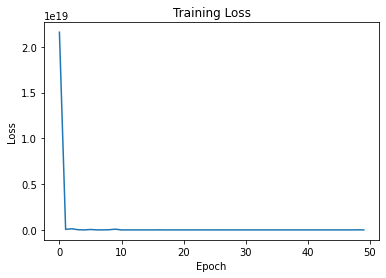

In [9]:
# %% Plot training loss
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [10]:
# %% Evaluation and Visualization of GCN Results
from geopy.distance import geodesic

model.eval()
errors_gcn = []

# Create test DataLoader
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing GCN"):
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)
        predicted_positions = out.cpu().numpy()
        true_positions = data.y.cpu().numpy()

        # Overwrite anchor nodes' positions with true positions (since anchors are known)
        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Calculate estimation errors for unknown nodes using Haversine distance
        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:  # Only for unknown nodes
                true_pos = (true_positions[idx][0], true_positions[idx][1])
                pred_pos = (predicted_positions[idx][0], predicted_positions[idx][1])
                error = geodesic(true_pos, pred_pos).meters
                errors_gcn.append(error)

# %% Convert errors to numpy arrays
errors_gcn = np.array(errors_gcn)

# Plot error distributions
plt.figure(figsize=(12, 6), facecolor='white')

plt.hist(errors_gcn, bins=20, alpha=0.7, label='GCN Errors', color='skyblue')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

# Print mean and median errors
print(f"GCN Mean Error: {errors_gcn.mean():.4f} meters, Median Error: {np.median(errors_gcn):.4f} meters")

# %% Visualization: Ground Truth vs. Predicted Positions
sample_data = data_list[0]  # Get a sample test graph for visualization
sample_data = sample_data.to(device)

with torch.no_grad():
    out = model(sample_data.x, sample_data.edge_index, sample_data.edge_attr, sample_data.anchor_mask)
    predicted_positions = out.cpu().numpy()
    true_positions = sample_data.y.cpu().numpy()

# Overwrite anchor nodes' positions with true positions (since anchors are known)
predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

# Plotting
plt.figure(figsize=(12, 6), facecolor='white')

# Ground truth positions
plt.scatter(true_positions[sample_data.unknown_mask.cpu(), 0], true_positions[sample_data.unknown_mask.cpu(), 1], 
            c='blue', label='True Unknown Node Positions', alpha=0.6)

# Predicted positions
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(), 0], predicted_positions[sample_data.unknown_mask.cpu(), 1], 
            c='red', label='Predicted Unknown Node Positions (GCN)', alpha=0.6)

# Anchor positions
plt.scatter(true_positions[sample_data.anchor_mask.cpu(), 0], true_positions[sample_data.anchor_mask.cpu(), 1], 
            c='green', label='Anchor Nodes', marker='^', s=100)

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Comparison of True vs. Predicted Node Positions')
plt.grid(True)
plt.show()


C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Testing GCN:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)
Testing GCN:   0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Latitude must be in the [-90; 90] range.

Testing GCN: 100%|██████████| 1000/1000 [00:03<00:00, 282.33it/s]


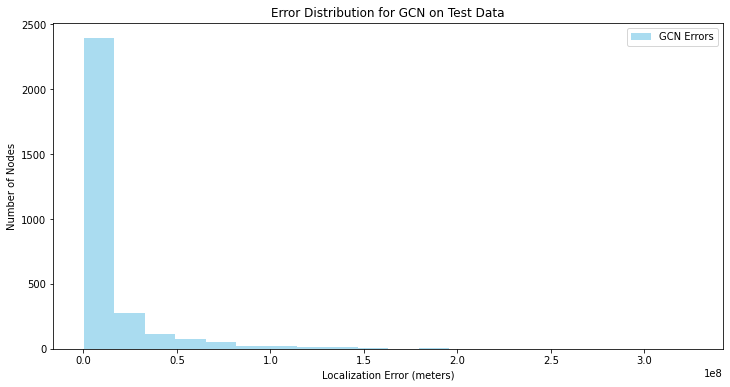

GCN Mean Error: 14827127.0000 meters, Median Error: 5148438.5000 meters


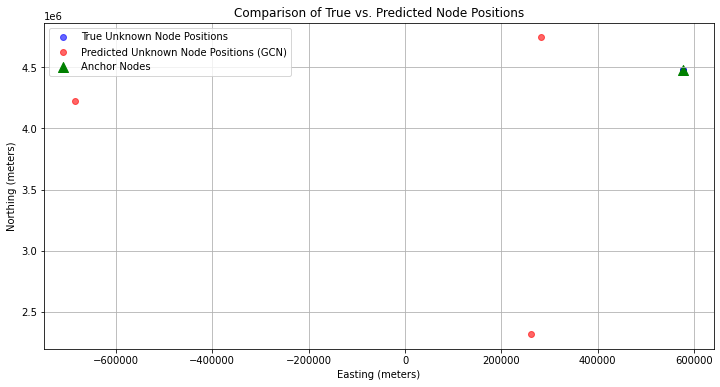

In [23]:
# %% Evaluation and Visualization of GCN Results
# Remove the geopy import since we won't use it
# from geopy.distance import geodesic

model.eval()
errors_gcn = []

# Create test DataLoader
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing GCN"):
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)
        predicted_positions = out.cpu().numpy()
        true_positions = data.y.cpu().numpy()

        # Overwrite anchor nodes' positions with true positions (since anchors are known)
        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Calculate estimation errors for unknown nodes using Euclidean distance
        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:  # Only for unknown nodes
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.linalg.norm(true_pos - pred_pos)
                errors_gcn.append(error)

# Convert errors to numpy arrays
errors_gcn = np.array(errors_gcn)

# Plot error distributions
plt.figure(figsize=(12, 6), facecolor='white')

plt.hist(errors_gcn, bins=20, alpha=0.7, label='GCN Errors', color='skyblue')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

# Print mean and median errors
print(f"GCN Mean Error: {errors_gcn.mean():.4f} meters, Median Error: {np.median(errors_gcn):.4f} meters")

# %% Visualization: Ground Truth vs. Predicted Positions
sample_data = data_list[0]  # Get a sample test graph for visualization
sample_data = sample_data.to(device)

with torch.no_grad():
    out = model(sample_data.x, sample_data.edge_index, sample_data.edge_attr, sample_data.anchor_mask)
    predicted_positions = out.cpu().numpy()
    true_positions = sample_data.y.cpu().numpy()

# Overwrite anchor nodes' positions with true positions (since anchors are known)
predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

# Plotting
plt.figure(figsize=(12, 6), facecolor='white')

# Ground truth positions
plt.scatter(true_positions[sample_data.unknown_mask.cpu(), 0], true_positions[sample_data.unknown_mask.cpu(), 1], 
            c='blue', label='True Unknown Node Positions', alpha=0.6)

# Predicted positions
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(), 0], predicted_positions[sample_data.unknown_mask.cpu(), 1], 
            c='red', label='Predicted Unknown Node Positions (GCN)', alpha=0.6)

# Anchor positions
plt.scatter(true_positions[sample_data.anchor_mask.cpu(), 0], true_positions[sample_data.anchor_mask.cpu(), 1], 
            c='green', label='Anchor Nodes', marker='^', s=100)

plt.legend()
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Comparison of True vs. Predicted Node Positions')
plt.grid(True)
plt.show()


In [11]:
predicted_positions

array([[5.7751106e+05, 4.4817250e+06],
       [5.7767106e+05, 4.4822365e+06],
       [5.8010606e+05, 4.4806260e+06],
       [5.7934506e+05, 4.4833765e+06],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02],
       [5.0173523e+01, 1.0297708e+02]], dtype=float32)